# CNN 무작정 실행해보기 : MNIST

## 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 데이터셋 불러오기

- 데이터셋 다운로드

In [ ]:
training_dataset = datasets.MNIST(root='dataset',
                                  train=True,
                                  download=True,
                                  transform=ToTensor(),
                                  )

test_dataset = datasets.MNIST(root='dataset',
                              train=False,
                              download=False,
                              transform=ToTensor(),
                              )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 80861269.61it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 24039629.65it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 36521487.06it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2227350.49it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



- 각 변수에 데이터셋이 담겨있는 상태

In [ ]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

## 데이터셋 구경하기

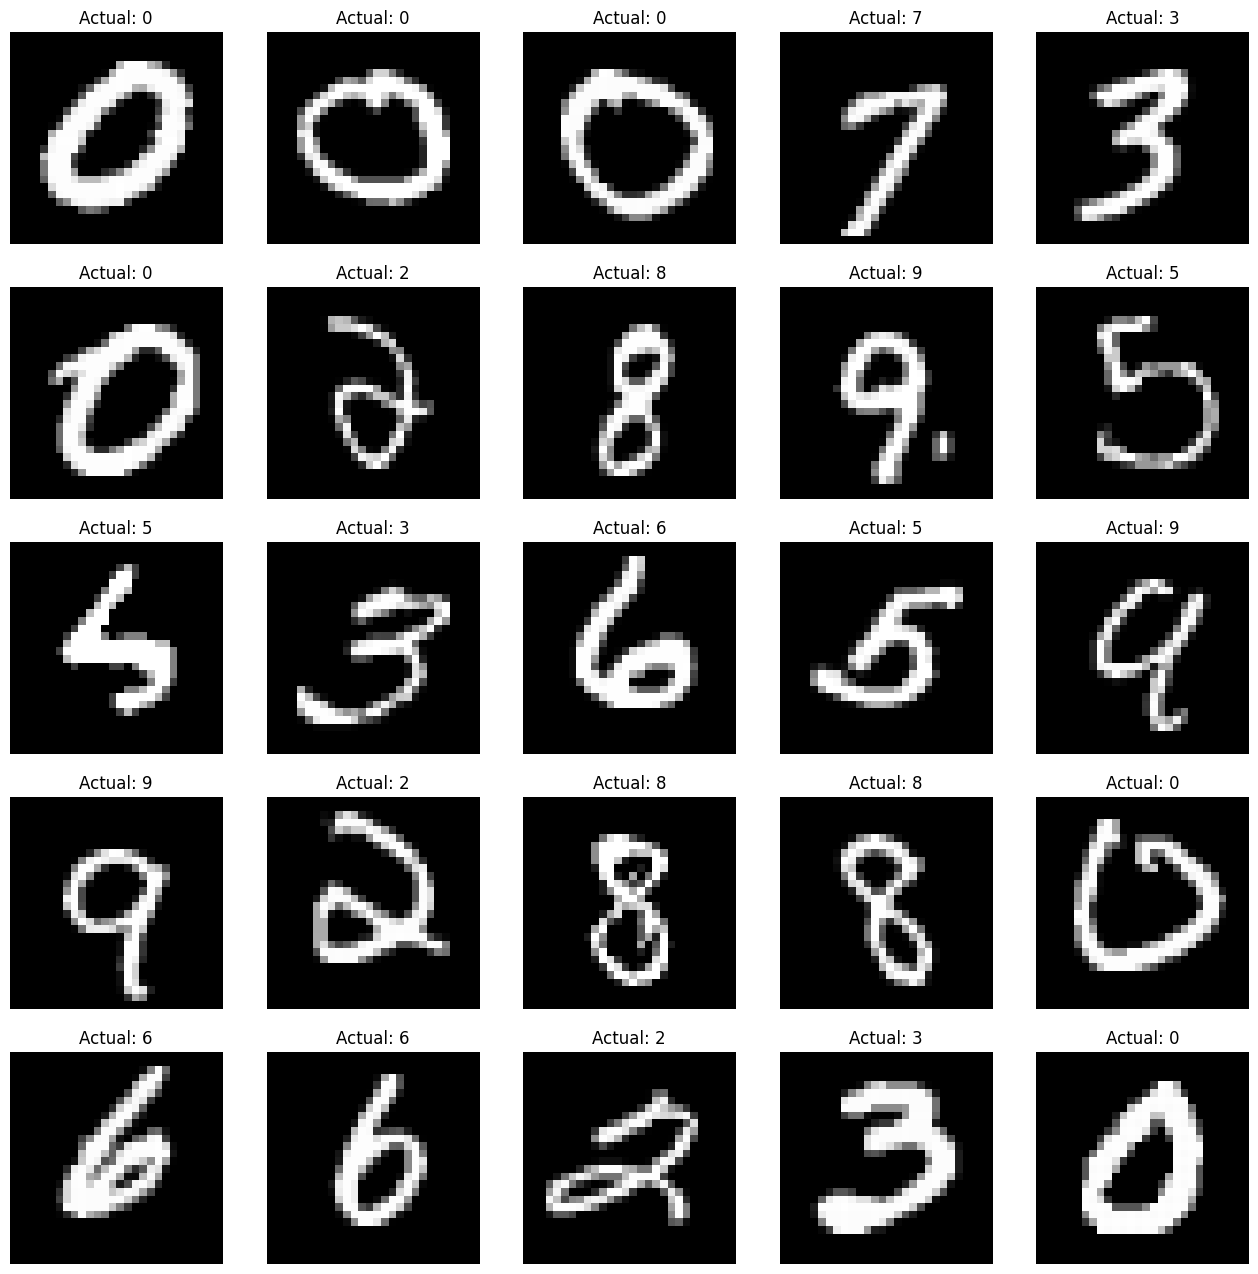

In [ ]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]

    plt.title(f'Actual: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## 데이터로더 생성하기
- 데이터셋을 순차적으로 조회 가능하도록 만드는 작업

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size
                             )

In [ ]:
train_dataloader

In [ ]:
for x, y in train_dataloader :
    print(f'학습 데이터의 형태 [N, C, H, W] : {x.shape}')
    print(f'정답 데이터의 형태 : {y.shape}')
    break

학습 데이터의 형태 [N, C, H, W] : torch.Size([32, 1, 28, 28])
정답 데이터의 형태 : torch.Size([32])


## 연산 장치 설정

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f'연산 장치 : {device}')

연산 장치 : cpu


## 모델 정의 및 생성

- 모델의 형태 구성

In [ ]:
class BasicCNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.basicCNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,
                      kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(7*7*64, 10)
        )

    def forward(self, x) :
        x = self.basicCNN(x)
        return x

In [ ]:
model = BasicCNN().to(device)
model

BasicCNN(
  (basicCNN): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=10, bias=True)
  )
)

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.19
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


- 손실 함수와 옵티마이저 설정

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters())

In [ ]:
loss_fn

CrossEntropyLoss()

In [ ]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

- 학습 절차를 함수화

In [ ]:
def train(dataloader, model, loss_fn, optim) :
    model.train()
    size = len(dataloader.dataset)

    for batch, (x, y) in enumerate(dataloader) :
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch % 100 == 0 :
            loss = loss.item()
            current = (batch+1) * len(x)
            print(f'[{current:5d}/{size:5d}] | loss: {loss:.4f}')

In [ ]:
def test(dataloader, model, loss_fn) :
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for x, y in dataloader :
            x, y = x.to(device), y.to(device)

            y_pred = model(x)
            test_loss = test_loss + loss_fn(y_pred, y).item()
            correct = correct + (y_pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss = test_loss / num_batches
    correct = correct / size

    print(f'Accuracy: {100*correct:.2f}% | Avg_loss: {test_loss:.4f}')

In [ ]:
epochs = 2

for e in range(epochs) :
    print(f'Epoch {e+1}')
    print('--------------------------')

    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
    print('--------------------------')

print('==============================')
print('End')

## 테스트 결과 살펴보기

In [ ]:
model.eval()

rand_idx = torch.randint(0, 10000, size=(1,)).item()
x, y = test_dataset[rand_idx][0].view((-1,1,28,28)), test_dataset[rand_idx][1]

with torch.no_grad() :
    x = x.to(device)
    y_pred = model(x)

    predicted = y_pred.argmax()
    actual = y

    print(f'Predicted: {predicted} | Actual: {actual}')

Predicted: 4 | Actual: 4


- 시각화 하여 살펴보기

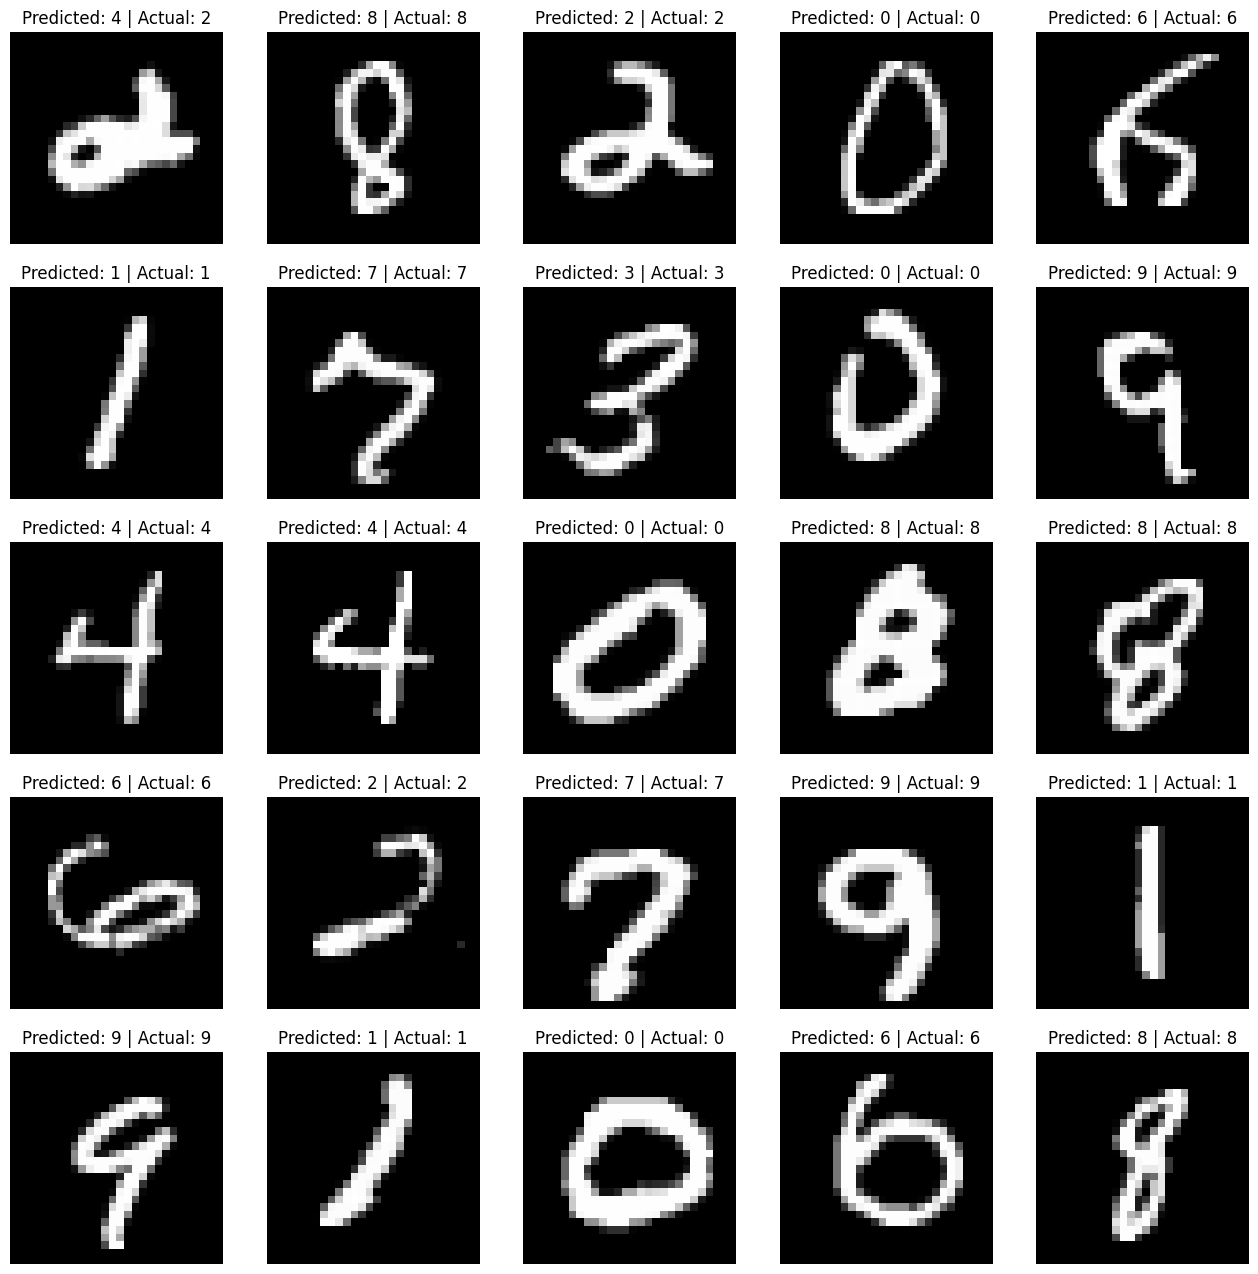

In [ ]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    rand_idx = torch.randint(0, 10000, size=(1,)).item()
    x, y = test_dataset[rand_idx][0].view((-1,1,28,28)), test_dataset[rand_idx][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax()
        actual = y

    # print(f'Predicted: {predicted} | Actual: {actual}')
    plt.title(f'Predicted: {predicted} | Actual: {actual}')
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")

plt.show()

- 틀린 것만 시각화 하여 살펴보기

In [ ]:
model.eval()

predicted_list, actual_list = [], []

for i in range(len(test_dataset)) :
    x, y = test_dataset[i][0].view((-1,1,28,28)), test_dataset[i][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax().item()
        actual = y

        predicted_list.append(predicted)
        actual_list.append(actual)

In [ ]:
predicted_list[:5], actual_list[:5]

([7, 2, 1, 0, 4], [7, 2, 1, 0, 4])

In [ ]:
false_idx_list = []

for i in range(len(predicted_list)) :
    if predicted_list[i] != actual_list[i] :
        false_idx_list.append(i)

false_idx_list[:5]

[211, 247, 290, 320, 321]

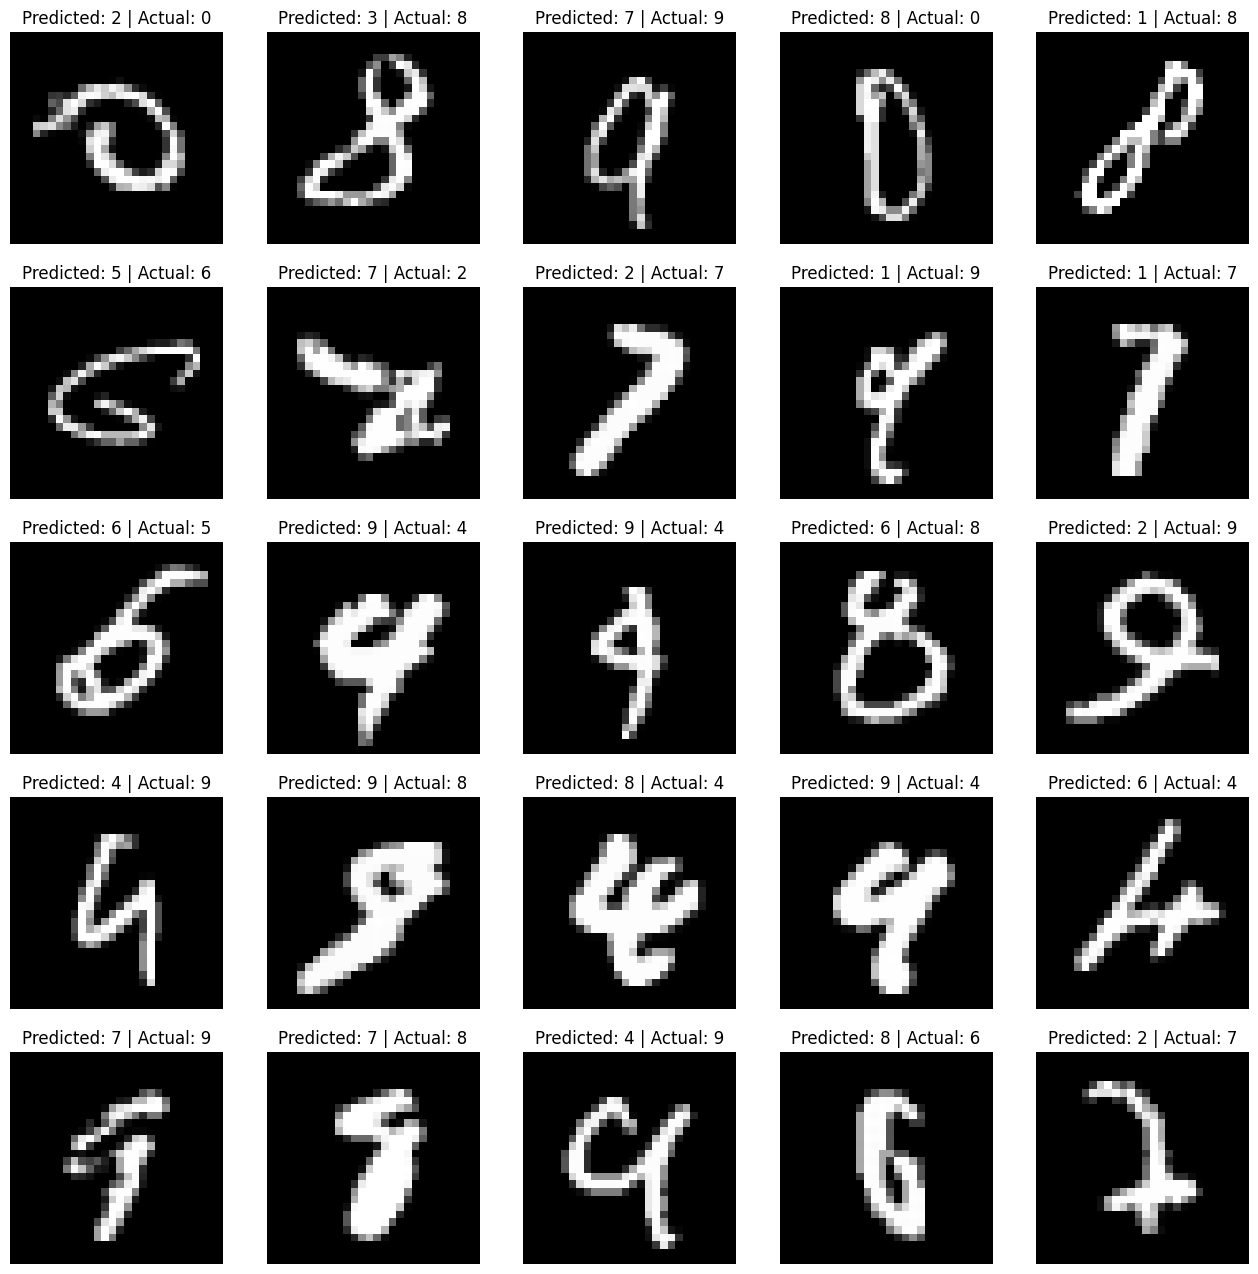

In [ ]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = false_idx_list[ torch.randint(len(false_idx_list), size=(1,)).item() ]

    with torch.no_grad() :
        temp_x = test_dataset[ sample_idx ][0].view((-1,1,28,28))
        temp_y_pred = model(temp_x)

        temp_predicted = temp_y_pred.argmax().item()
        temp_actual = test_dataset[ sample_idx ][1]

    plt.title(f'Predicted: {temp_predicted} | Actual: {temp_actual}')
    plt.axis("off")
    plt.imshow(temp_x.squeeze(), cmap="gray")

plt.show()